In [79]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc, make_scorer, accuracy_score, precision_score, f1_score, classification_report


sns.set_style('darkgrid')
plot_txt_colr = '#046169'
plot_params = {'font.size':25,
               'axes.facecolor':'#66b3b3',
               'figure.facecolor':'white',
               'axes.edgecolor':'purple',
               'text.color':plot_txt_colr,
               'axes.labelcolor':plot_txt_colr,
               'xtick.color':plot_txt_colr,
               'ytick.color':plot_txt_colr
              }
plt.rcParams.update(plot_params)

In [80]:
df = pd.read_csv('Churn.csv')
df.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
df.head()
unedited = df

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account_length          3333 non-null   int64  
 2   area_code               3333 non-null   int64  
 3   phone_number            3333 non-null   object 
 4   international_plan      3333 non-null   object 
 5   voice_mail_plan         3333 non-null   object 
 6   number_vmail_messages   3333 non-null   int64  
 7   total_day_minutes       3333 non-null   float64
 8   total_day_calls         3333 non-null   int64  
 9   total_day_charge        3333 non-null   float64
 10  total_eve_minutes       3333 non-null   float64
 11  total_eve_calls         3333 non-null   int64  
 12  total_eve_charge        3333 non-null   float64
 13  total_night_minutes     3333 non-null   float64
 14  total_night_calls       3333 non-null   

***
# First Round Filtering
***

In [82]:
df = df.drop(columns=['phone_number'], axis=1)

***
# Cursory Churn Info
***

In [83]:
print(df['churn'].value_counts())

False    2850
True      483
Name: churn, dtype: int64


In [84]:
df['charge_total'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge'] + df['total_intl_charge']

In [85]:
print(df['charge_total'].describe())

count    3333.000000
mean       59.449754
std        10.502261
min        22.930000
25%        52.380000
50%        59.470000
75%        66.480000
max        96.150000
Name: charge_total, dtype: float64


In [121]:
print('$',round(sum(df['charge_total'])),'| $',round(0.17*sum(df['charge_total'])))


print('\nif your total yearly income was $',200000,'then you would risk losing $',round(200000*.17), 'a year to churn')

$ 198146 | $ 33685

if your total yearly income was $ 200000 then you would risk losing $ 34000 a year to churn


Assuming the charges are represented in dollars, the left column is the total sum of all charges, and the right is 17% of that, or the amount of churn dollars to be lost

Text(0.5, 1.0, 'Total Charge vs Churn')

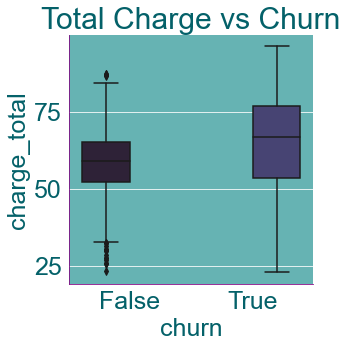

In [97]:
ch_ch = df[['churn','charge_total']]
sns.catplot(x='churn',y='charge_total',kind="box",palette=sns.color_palette("mako"), hue='churn',data = ch_ch)
plt.title('Total Charge vs Churn')

This chart shows the bulk of churn is on the higher side of total charge

***
***

In [71]:
#check for high correlations to drop -- in this version the correlations are manually translated to the to_drop column; the threshold is higher than .98
corr = df.corr()
corr.style.background_gradient(cmap='tab20c')

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,charge_total
account_length,1.000000,-0.012463,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796,0.016541,0.001454
area_code,-0.012463,1.000000,-0.001994,-0.008264,-0.009646,-0.008264,0.003580,-0.011886,0.003607,-0.005825,0.016522,-0.005845,-0.018288,-0.024179,-0.018395,0.027572,0.006174,-0.008393
number_vmail_messages,-0.004628,-0.001994,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263,-0.089728,0.009766
total_day_minutes,0.006216,-0.008264,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423,0.205151,0.884754
total_day_calls,0.038470,-0.009646,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942,0.018459,0.003673
total_day_charge,0.006214,-0.008264,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427,0.205151,0.884757
total_eve_minutes,-0.006757,0.003580,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985,0.092796,0.413143
total_eve_calls,0.019260,-0.011886,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423,0.009233,0.009392
total_eve_charge,-0.006745,0.003607,0.017578,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074,-0.012987,0.092786,0.413129
total_night_minutes,-0.008955,-0.005825,0.007681,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180,-0.009288,0.035493,0.214257


In [6]:
#corr is a subset of df so only one difference is needed to view the missing columns
#these columns cannot be compared via corr because they are objects
df_objects = df.columns.difference(corr.columns)
print(df_objects)

Index(['international_plan', 'state', 'voice_mail_plan'], dtype='object')


In [7]:
#checking variance filter options
for col in df:
    try:
        print(col, np.var(df[col]))
    except:
        pass

account_length 1585.3243329733511
area_code 1794.7876056732252
number_vmail_messages 187.31512953276192
total_day_minutes 2965.8063885668544
total_day_calls 402.64729839320404
total_day_charge 85.71140454767361
total_eve_minutes 2571.1223710759846
total_eve_calls 396.7919133947592
total_eve_charge 18.57628041518822
total_night_minutes 2556.9466108212923
total_night_calls 382.815581108068
total_night_charge 5.17804313864331
total_intl_minutes 7.7920295197836875
total_intl_calls 6.055758231088608
total_intl_charge 0.5680026826084938
customer_service_calls 1.7299974821964845
churn 0.12391428161718061


<div style='color:teal'>Although <i>customer service calls</i> has a higher correlation with <i>churn</i> and a lower variance it was kept because its removal negatively impacted the first model</div>

In [78]:
#high correlations to drop
#phone number is dropped as personal judgement call
to_drop = ['total_day_charge', 'total_eve_charge', 'total_night_charge', 'total_intl_charge','charge_total']
df = df.drop(columns = to_drop, axis=1)

In [9]:
#inspect unique values for any filler inputs or unexpected entries
for col in df:
    print(col+':\n',df[col].unique(),'\n')

state:
 ['KS' 'OH' 'NJ' 'OK' 'AL' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY'
 'ID' 'VT' 'VA' 'TX' 'FL' 'CO' 'AZ' 'SC' 'NE' 'WY' 'HI' 'IL' 'NH' 'GA'
 'AK' 'MD' 'AR' 'WI' 'OR' 'MI' 'DE' 'UT' 'CA' 'MN' 'SD' 'NC' 'WA' 'NM'
 'NV' 'DC' 'KY' 'ME' 'MS' 'TN' 'PA' 'CT' 'ND'] 

account_length:
 [128 107 137  84  75 118 121 147 117 141  65  74 168  95  62 161  85  93
  76  73  77 130 111 132 174  57  54  20  49 142 172  12  72  36  78 136
 149  98 135  34 160  64  59 119  97  52  60  10  96  87  81  68 125 116
  38  40  43 113 126 150 138 162  90  50  82 144  46  70  55 106  94 155
  80 104  99 120 108 122 157 103  63 112  41 193  61  92 131 163  91 127
 110 140  83 145  56 151 139   6 115 146 185 148  32  25 179  67  19 170
 164  51 208  53 105  66  86  35  88 123  45 100 215  22  33 114  24 101
 143  48  71 167  89 199 166 158 196 209  16  39 173 129  44  79  31 124
  37 159 194 154  21 133 224  58  11 109 102 165  18  30 176  47 190 152
  26  69 186 171  28 153 169  13  27   3  42 189 156 134

<p style="color:teal">At first glance there don't appear to be any filler values</p>

***
# Convert nominal and ordinal objects for ML
***

In [10]:
for col in df_objects:
    print(col+':\n',df[col].unique())


international_plan:
 ['no' 'yes']
state:
 ['KS' 'OH' 'NJ' 'OK' 'AL' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY'
 'ID' 'VT' 'VA' 'TX' 'FL' 'CO' 'AZ' 'SC' 'NE' 'WY' 'HI' 'IL' 'NH' 'GA'
 'AK' 'MD' 'AR' 'WI' 'OR' 'MI' 'DE' 'UT' 'CA' 'MN' 'SD' 'NC' 'WA' 'NM'
 'NV' 'DC' 'KY' 'ME' 'MS' 'TN' 'PA' 'CT' 'ND']
voice_mail_plan:
 ['yes' 'no']


<div style="color:teal">Each set in df_objects represents nominal data, and should therefore be converted to binary dummy columns</div>

<div style="color:#003434;background:teal">Additionally area code represents a set of nominal data values</div>

In [11]:
nominal = ['area_code']
for obj_name in df_objects:
    nominal.append(obj_name)

In [12]:
encoded = pd.get_dummies(df, columns = nominal)

In [13]:
#another look at the correlation matrix
encoded_corr = encoded.corr()
encoded_corr.style.background_gradient(cmap='tab20c')

<div style="color:teal">One new high correlation can be observed between <i>number vmail messages</i> category and <i>voice mail plan_yes</i></div>
<div style="color:teal">Actually, number vmail messages is also highly negatively correlated with <i>voice mail plan_no</i> so it will be chosen as the column to be dropped</div>

In [14]:
encoded = encoded.drop(columns=['number_vmail_messages'],axis=1)

In [15]:
encoded_feat = encoded.drop(columns=['churn'],axis=1)
scaled = pd.DataFrame(StandardScaler().fit_transform(encoded_feat),columns=encoded_feat.columns)
scaled['churn'] = encoded['churn']

***
# Churn vs No Churn Visuals
***

In [16]:
churn = encoded.loc[encoded['churn'] == True]
no_churn = encoded.loc[encoded['churn']==False]


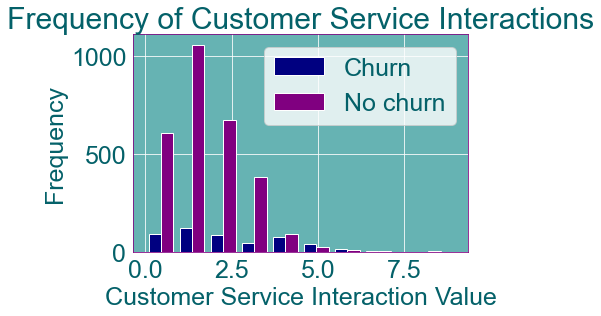

In [17]:
css = churn["customer_service_calls"]
css_nc = no_churn["customer_service_calls"]

plt.hist([css,css_nc],label=['Churn','No churn'], color=['#000080','purple'])
plt.title('Frequency of Customer Service Interactions')
plt.xlabel('Customer Service Interaction Value')
plt.ylabel('Frequency')
plt.legend(facecolor='white')

The above plot might not have very much value It shows the frequency of calls is somewhat normally distributed when there was no churn, and about the same across the board for churn customers. Maybe if the relative frequency was plotted for each, a conclusion could be drawn about what percentage of churn/non-churn cam from which customer service interaction value.

***
# Imbalance Check
***

In [18]:
encoded['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

<div style="color:teal">Very imbalanced dataset</div>
<div style="color:teal">ADASYN will be employed on training set</div>
<div style="color:teal">Also a single class classifier might be worth considering</div>

***
# First Model Test - XGBoost (Model #1)
***

In [19]:
X = encoded.drop(columns=['churn'],axis=1)
y = encoded['churn']

In [20]:
X_train,X_test, y_train, y_test = train_test_split(X,y, train_size=.75, random_state=42)

In [21]:
X_train_resampled, y_train_resampled = ADASYN().fit_sample(X_train, y_train)

In [22]:
clf1 = xgb.XGBClassifier()
clf1.fit(X_train_resampled, y_train_resampled)

y_hat1 = clf1.predict(X_test)

print(classification_report(y_test,y_hat1))

              precision    recall  f1-score   support

       False       0.95      0.98      0.96       709
        True       0.84      0.70      0.76       125

    accuracy                           0.93       834
   macro avg       0.89      0.84      0.86       834
weighted avg       0.93      0.93      0.93       834



In [23]:
clf1b = xgb.XGBClassifier(max_depth = 4)
clf1b.fit(X_train, y_train)

y_hat1b = clf1b.predict(X_test)

print(classification_report(y_test,y_hat1b))

              precision    recall  f1-score   support

       False       0.96      0.99      0.97       709
        True       0.94      0.74      0.83       125

    accuracy                           0.95       834
   macro avg       0.95      0.86      0.90       834
weighted avg       0.95      0.95      0.95       834



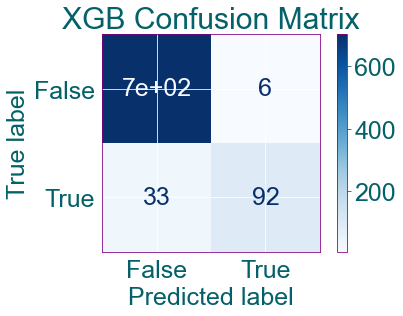

In [24]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf1b,X_test,y_test, cmap=plt.cm.Blues)
plt.title('XGB Confusion Matrix')
plt.show()

<div style="color:teal">So the model actually seems to perform better without the resampled data set - Resampling might automatically be included in XGB, documentation should be referenced</div>
<div style="color:teal">XGBoost was expected to perform well; now to see if f1 can be improved on this model. Also try other models...</div>

In [25]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/Steve/Anaconda3/Library/bin/graphviz'

In [26]:
feature_imp = pd.DataFrame({'Variable':X.columns,
                            'Importance':clf1b.feature_importances_}).sort_values('Importance', ascending=False)
feature_imp.head(10)

,Variable,Importance
9,customer_service_calls,0.153934
1,total_day_minutes,0.108776
13,international_plan_no,0.100328
66,voice_mail_plan_no,0.095666
7,total_intl_minutes,0.089930
8,total_intl_calls,0.079565
3,total_eve_minutes,0.063547
5,total_night_minutes,0.035550
46,state_NJ,0.027677
50,state_OH,0.026437


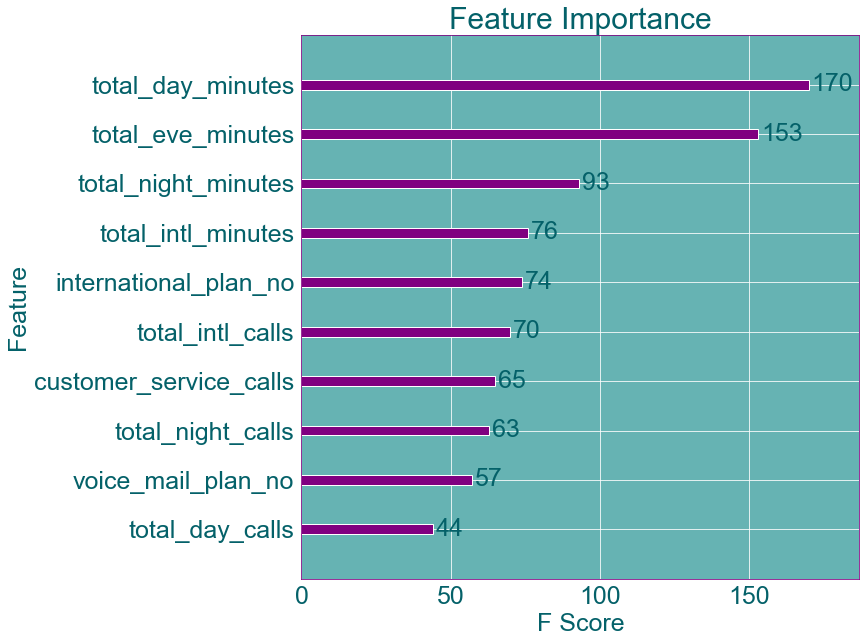

In [27]:
fig1, ax1 = plt.subplots(figsize=(10,10))
xgb.plot_importance(clf1b, max_num_features=10, ax=ax1, color="purple")
plt.title('Feature Importance')
plt.xlabel('F Score')
plt.ylabel('Feature')
plt.show()

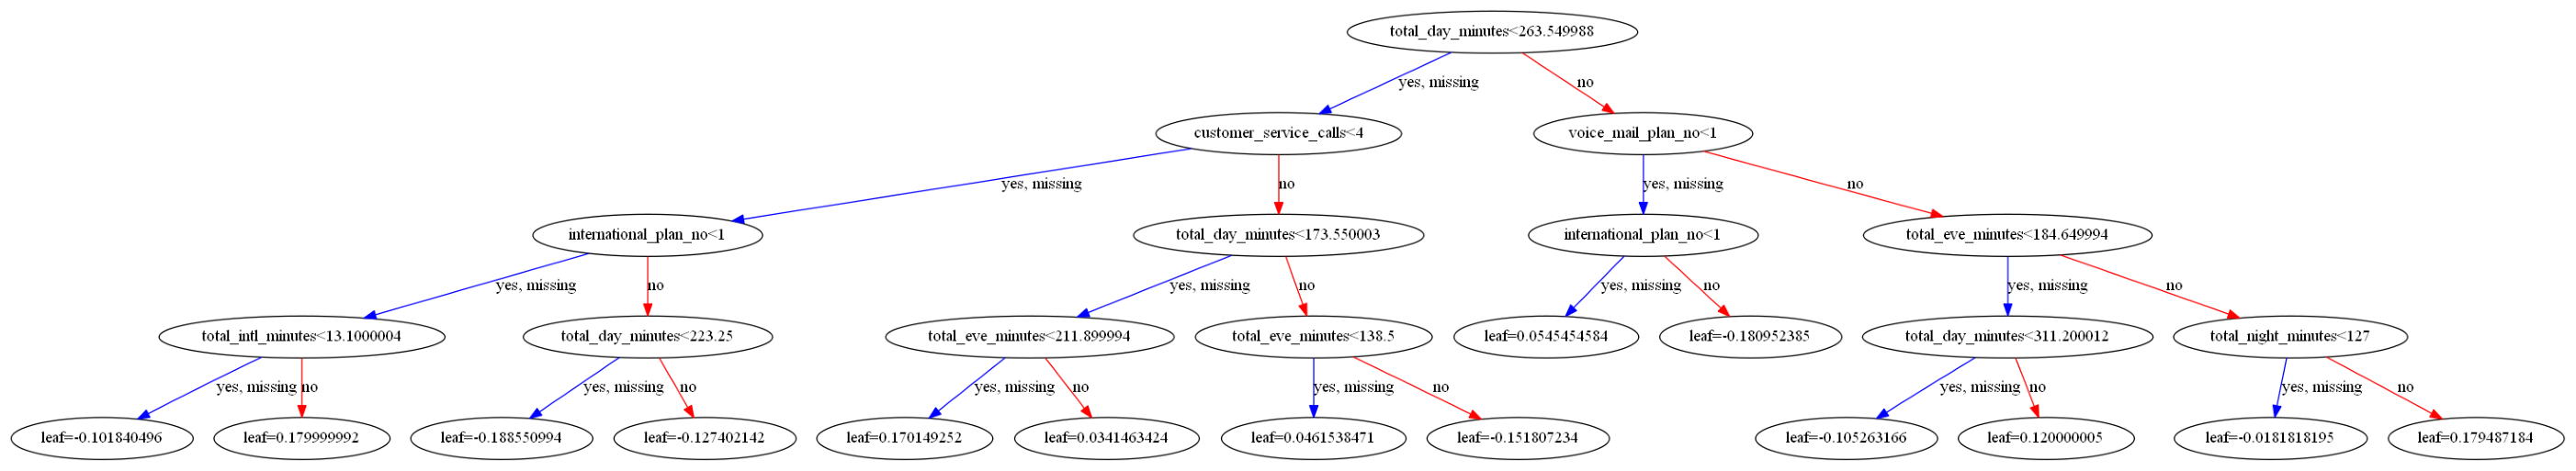

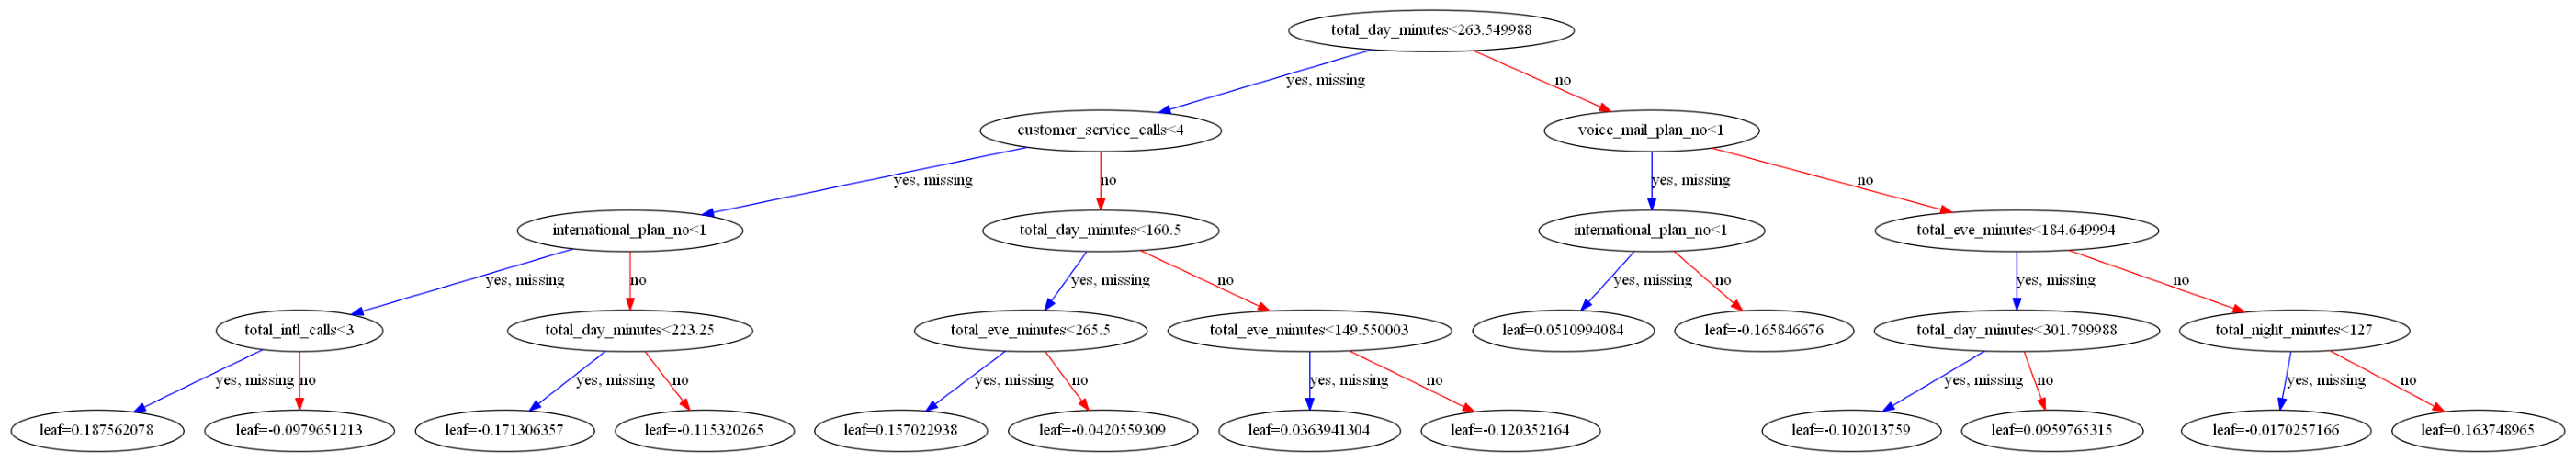

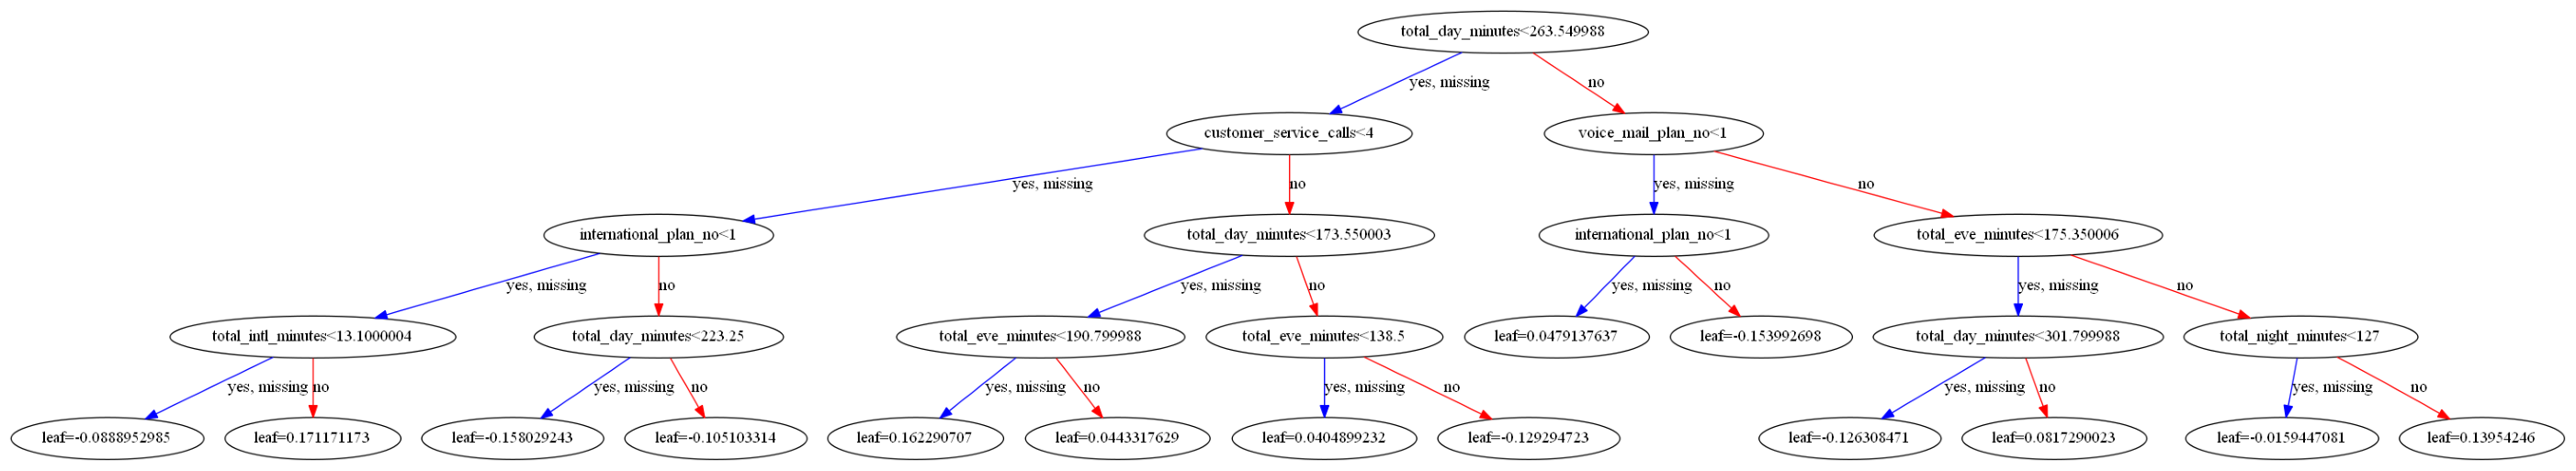

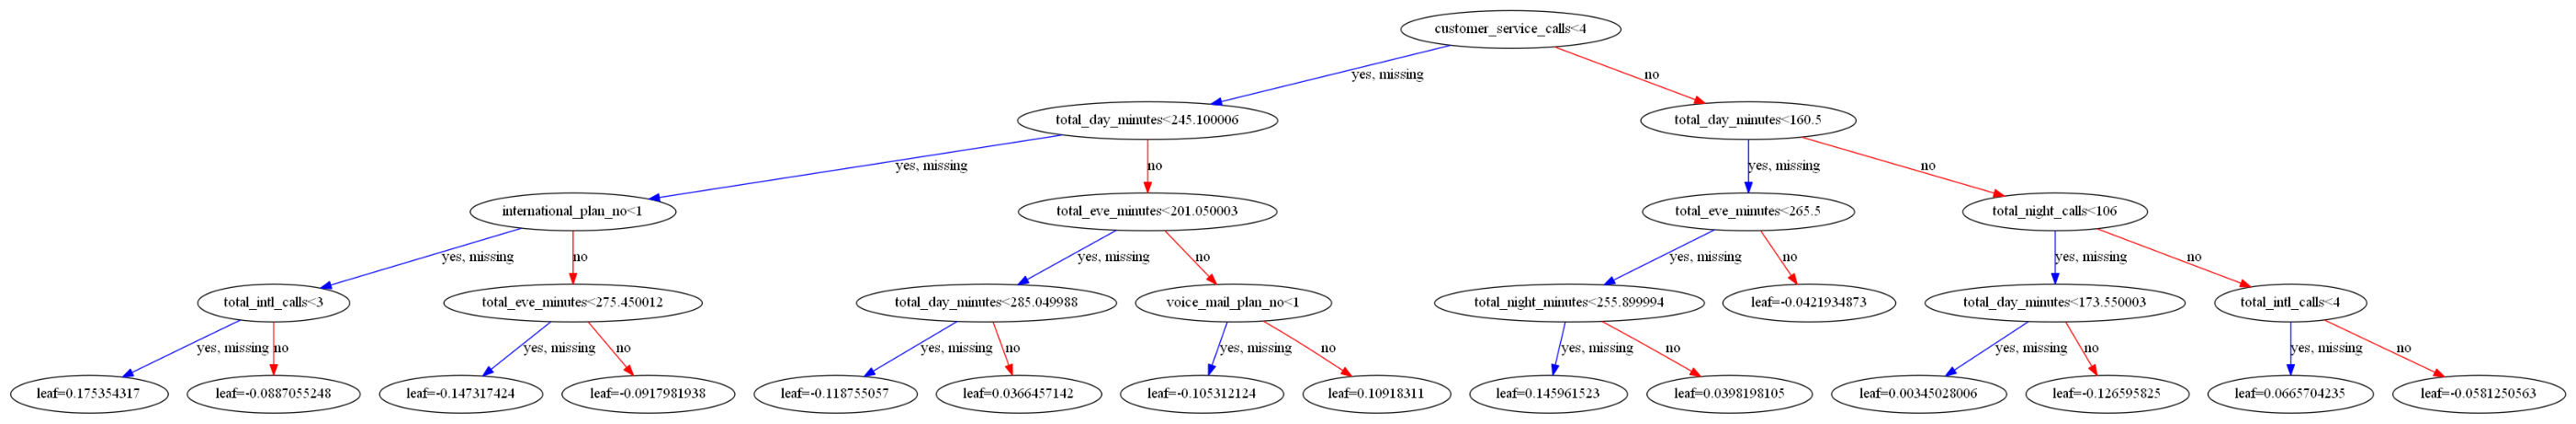

In [28]:
import graphviz
# fig2, ax2 = plt.subplots(figsize=(50, 50))
# xgb.plot_tree(clf1b, num_trees=0, rankdir="UT", ax=ax2)
# plt.show()
for i in range(4):
    fig, ax = plt.subplots(figsize=(50, 50))
    xgb.plot_tree(clf1b, num_trees=i, rankdir="UT", ax=ax)
    plt.show()

In [29]:
leaf_title = []
leaves = []
booster = clf1b.get_booster()
tree = booster.get_dump()[0]
tree = tree.split()
for i, text in enumerate(tree):
      #print(text)
      if 'leaf' in text:#if text[0].isdigit():
            leaves.append(text[len('leaf')+4:])
            #print(text[len('leaf')+4:])
for i, leaf in enumerate(leaves):
    print(i,leaf)
# print(enumerate(clf1b.get_booster().get_dump()[0].split()))

0 -0.101840496
1 0.179999992
2 -0.188550994
3 -0.127402142
4 0.170149252
5 0.0341463424
6 0.0461538471
7 -0.151807234
8 0.0545454584
9 -0.180952385
10 -0.105263166
11 0.120000005
12 -0.0181818195
13 0.179487184


# → convert to probability score via logistic function: 1/(1+np.exp(-1*leaf_node_value))

In [30]:
#Example: probability of churn=True for total day minutes:
def logistic(x):
    return 1/(1+np.exp(-1*x))
def prob_sum(start,stop):
   return sum([logistic(float(leaves[i])) for i in range(start,stop)])

tot = prob_sum(0,14)
print('leaf node totals: ',tot,'\n','***','\n')


#examining total day minutes given tdm < 264 and csc < 4 and intl plan = 1
prob_leaf_1 = prob_sum(0,8)
prob_leaf_2 = prob_sum(8,14)

print('leaf one prob: ',[leaves[i] for i in range(0,8)],prob_leaf_1)
print('leaf two prob: ',[leaves[i] for i in range(8,14)],prob_leaf_2)

prob_dict = {}
for i in range(len(leaves)):
    print(i+1, '-->',leaves[i],'\n Probability Churn = True -->', logistic(i)*100)
    prob_dict[leaves[i]] = logistic(i)*100
# print(prob_leaf_1+prob_leaf_2)

leaf node totals:  6.977659543411497 
 *** 

leaf one prob:  ['-0.101840496', '0.179999992', '-0.188550994', '-0.127402142', '0.170149252', '0.0341463424', '0.0461538471', '-0.151807234'] 3.96526269676551
leaf two prob:  ['0.0545454584', '-0.180952385', '-0.105263166', '0.120000005', '-0.0181818195', '0.179487184'] 3.0123968466459874
1 --> -0.101840496 
 Probability Churn = True --> 50.0
2 --> 0.179999992 
 Probability Churn = True --> 73.1058578630005
3 --> -0.188550994 
 Probability Churn = True --> 88.07970779778823
4 --> -0.127402142 
 Probability Churn = True --> 95.25741268224334
5 --> 0.170149252 
 Probability Churn = True --> 98.20137900379085
6 --> 0.0341463424 
 Probability Churn = True --> 99.33071490757153
7 --> 0.0461538471 
 Probability Churn = True --> 99.75273768433654
8 --> -0.151807234 
 Probability Churn = True --> 99.90889488055994
9 --> 0.0545454584 
 Probability Churn = True --> 99.96646498695337
10 --> -0.180952385 
 Probability Churn = True --> 99.98766054240137

In [31]:
data = list(prob_dict.items())
tree = np.array(data)
tree = pd.DataFrame(tree)
tree.to_excel('D:\Documents\FlatIronCourseMaterialV2\mod3\FinalProject\FISP3\TreeTable.xlsx')

<div style="color:black;background:white">Note that every branch off of total_day_minutes > 264 has a probability of 99.9% Furthurmore, when total_day_minutes > 160 there remains a 99% probability of churn <br>It also doesn't seem surprising that when international calls and total call minutes are down there is a lower probability of churn. Refer to the linear relationship between total day minutes and total day charge.</div>

In [32]:
x_threshold = [174,223,264]
y_threshold = [29.58,37.91,44.88]
'''for x_ in x_threshold:
    y_threshold.append(unedited['total_day_charge'].loc[unedited['total_day_minutes']==x_])
print(y_threshold)'''

"for x_ in x_threshold:\n    y_threshold.append(unedited['total_day_charge'].loc[unedited['total_day_minutes']==x_])\nprint(y_threshold)"

Text(0.5, 0, 'Total Day Minutes')

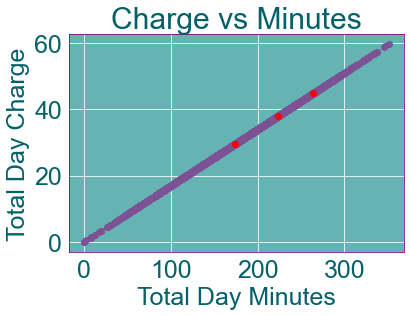

In [33]:
plt.scatter(y=unedited['total_day_charge'],x=unedited['total_day_minutes'], color='#7c5295')
plt.scatter(y=y_threshold,x=x_threshold,color="red")
plt.rcParams['axes.facecolor'] = '#66b3b3'
plt.rcParams['figure.facecolor']='white'
plt.rcParams['axes.edgecolor'] = 'purple'
plt.title('Charge vs Minutes')
plt.ylabel('Total Day Charge')
plt.xlabel('Total Day Minutes')

Text(0, 0.5, 'Total Intl Minutes')

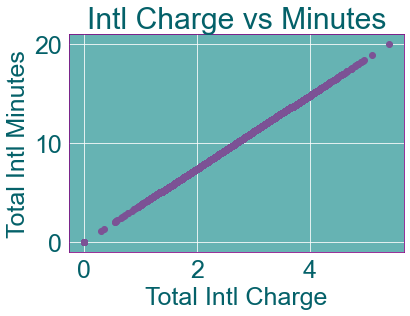

In [34]:
plt.scatter(x=unedited['total_intl_charge'],y=unedited['total_intl_minutes'], color='#7c5295')
plt.title('Intl Charge vs Minutes')
plt.xlabel('Total Intl Charge')
plt.ylabel('Total Intl Minutes')

# KFold Models

In [35]:
# from sklearn.model_selection import KFold
# KF_X = np.X
# KF_y = y
# kf = KFold(n_splits=5)
# kf.get_n_splits(KF_X)

# for train_index, test_index in kf.split(KF_X):
#     KF_X_train, KF_X_test = KF_X[train_index], KF_X[test_index]
#     KF_y_train, KF_y_test = KF_y[train_inex], KF_y[test_index]
       
#     clf_kf = xgb.XGBClassifier()
#     clf_kf.fit(KF_X_train, KF_y_train)
#     y_hat_kf = clf_kf.predict(KF_X_test)

#     print(classification_report(KF_y_test,y_hat_kf))
        

### <div style='color:#990F02;background:#BC544B;padding:16px'>XGB Hyperperameter Tuning</div>

In [36]:
clf1c = xgb.XGBClassifier() #'verbosity' = 2
clf1c.fit(X_train,y_train)

y_hat1c = clf1c.predict(X_test)

print(classification_report(y_test, y_hat1c))

              precision    recall  f1-score   support

       False       0.95      0.99      0.97       709
        True       0.95      0.70      0.81       125

    accuracy                           0.95       834
   macro avg       0.95      0.85      0.89       834
weighted avg       0.95      0.95      0.95       834



In [37]:
scoring = {'AUC': 'roc_auc', 'F1': make_scorer(f1_score)}

In [38]:
# hypes = {#'eta':[.3,.6,.9],
#          'gamma':[0,5,100,150],
#          'max_depth':[1,6,100],
#          'min_child_weight':[1,10,100],
#          'max_delta_step':[0,1,5,10],
#          'subsample':[.25,.5,.75,1],
#          'sampling_method':['uniform','gradient_based'],
#          'lambda':[1,5,50],
#          'alpha':[0,5,50],
#          'max_leaves':[0,5,50],
#          'num_pparallel_tree':[1,5,20]
#         }



hypes = {"learning_rate": [0.1,.3],
    'max_depth': [6],
    'min_child_weight': [1,10],
    'subsample': [ 0.7,1],
    'n_estimators': [5, 30, 100]
        }


In [39]:
gnb_clf1c = GridSearchCV(estimator=clf1c, param_grid = hypes, scoring=scoring, refit='F1', cv=5, return_train_score=True)

gnb_clf1c.fit(X_train_resampled, y_train_resampled)
gnb_clf1c.score(X_test, y_test)
#After some grid searching none of the new models performed any better than the original with untuned parameters - which might actually be a result of the fact that cross validation is 
#now included
#best f1 was 0.843

best_parameters = gnb_clf1c.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = gnb_clf1c.predict(X_train_resampled)
val_preds = gnb_clf1c.predict(X_test)
training_f1 = f1_score(y_train_resampled, training_preds)
val_f1 = f1_score(y_test, val_preds)

print("")
print("Training f1: {:.4}%".format(training_f1 * 100))
print("Validation f1: {:.4}%".format(val_f1 * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.3
max_depth: 6
min_child_weight: 1
n_estimators: 100
subsample: 1

Training f1: 100.0%
Validation f1: 84.98%


<div style='color:teal'>Although a f1 of 100% is alarming, the validation run sits at an 84.8% which shows no overfitting seemed to occur<br><br>
It can also be observed that the cross validated f1-score is even higher than the single model tested above
</div>

### <div style='color:#990F02;background:#BC544B;padding:35px'></div>

***
# Second Model - Naive Bayes (Model #2)
***

In [40]:
# vanilla naive bayes
gnb = GaussianNB()
gnb.fit(X_train,y_train)

y_hat2 = gnb.predict(X_test)

print(classification_report(y_test,y_hat2))

              precision    recall  f1-score   support

       False       0.88      0.57      0.69       709
        True       0.19      0.58      0.29       125

    accuracy                           0.57       834
   macro avg       0.54      0.57      0.49       834
weighted avg       0.78      0.57      0.63       834



In [41]:
'''priors = []
for i in range(1,100):
    i=i*.01
    priors.append([round(i,2),round(1-i,2)])'''

'priors = []\nfor i in range(1,100):\n    i=i*.01\n    priors.append([round(i,2),round(1-i,2)])'

In [42]:
'''var_smooth = []
for i in range(2,16):
    var_smooth.append(10**(-i))'''

'var_smooth = []\nfor i in range(2,16):\n    var_smooth.append(10**(-i))'

In [43]:

'''gnb_grid = [{'priors':priors,
            'var_smoothing': var_smooth}]
gridsearch = GridSearchCV(estimator=gnb, param_grid = gnb_grid, scoring=scoring, refit='F1', cv=5, return_train_score=True)

gridsearch.fit(X_train_resampled, y_train_resampled)
gridsearch.score(X_test, y_test)'''

# scores = [x for x in gridsearch.cv_results_]
# print(scores)
# # print(gridsearch.cv_results_)

#Top output for this model f1 score was 0.468

"gnb_grid = [{'priors':priors,\n            'var_smoothing': var_smooth}]\ngridsearch = GridSearchCV(estimator=gnb, param_grid = gnb_grid, scoring=scoring, refit='F1', cv=5, return_train_score=True)\n\ngridsearch.fit(X_train_resampled, y_train_resampled)\ngridsearch.score(X_test, y_test)"

<div style='color:teal'>This model underperforms the XBG model by a large margin (both original and resampled datasets). One more model is probably worth trying, after that improvements to the XGB model may be the most useful means for better outputs.</div>

***
# Third Model - Linear SVC (Model #3)
***

In [44]:
clf3 = SVC()
clf3.fit(X_train_resampled, y_train_resampled)

y_hat3 = clf3.predict(X_test)

print(classification_report(y_test,y_hat3))

              precision    recall  f1-score   support

       False       0.92      0.90      0.91       709
        True       0.48      0.54      0.51       125

    accuracy                           0.84       834
   macro avg       0.70      0.72      0.71       834
weighted avg       0.85      0.84      0.85       834



Second best f1 yet, 29.7% difference compared to best XGB model:
(.74-.52)/(.74)

In [45]:
clf3b = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf3b.fit(X_train,y_train)
y_hat3b = clf3b.predict(X_test)

print(classification_report(y_test,y_hat3b))

              precision    recall  f1-score   support

       False       0.86      0.99      0.92       709
        True       0.56      0.08      0.14       125

    accuracy                           0.85       834
   macro avg       0.71      0.53      0.53       834
weighted avg       0.81      0.85      0.80       834



<div style='color:teal'>initial performance is so low, it is probably not worth the effort/time to develop this model, especially when comparing time complexity and f1 score with XGB</div>